In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
from sklearn.cluster import KMeans
from collections import Counter
import calmap

In [2]:
file_content = pd.read_csv("../five_min_frame.zip")

In [21]:
stations_list = pd.unique(file_content[file_content['% Observed']>=100].Station.ravel())
stations_list[:4]

array([1100313, 1100326, 1100330, 1100333])

In [22]:
def TransformStation(station_id):
    df = file_content.loc[file_content['Station'] == station_id,:]
    df.loc[:,'Timestamp'] = df['Timestamp'].apply(lambda x:pd.to_datetime(x, format='%m/%d/%Y %H:%M:%S'))
    df.loc[:,'Time'] = df['Timestamp'].apply(lambda x:x.time())
    df.loc[:,'Date'] = df['Timestamp'].apply(lambda x:x.date())
    df = df[['Date','Time','Station','Total Flow']]
    df = df.sort_values(['Date','Time'])
    return df

def MakeMatrix(df):
    data = df.as_matrix()
    dates, dates_index = np.unique(data[:, 0], return_inverse=True) #dates
    times, times_index = np.unique(data[:, 1], return_inverse=True) #times
    stations, stations_index = np.unique(data[:, 2], return_inverse=True) #stations
    pivot_table = np.zeros((len(times), len(stations), len(dates)), dtype=data.dtype)
    pivot_table[times_index, stations_index, dates_index] = data[:, 3]

    # create 2D flattened version of 3D input array
    d1,d2,d3 = pivot_table.shape
    b = np.zeros([d1,d2*d3])
    for i in range(len(pivot_table)):
        b[i] = pivot_table[i].flatten()
    
    return b

def PlotElbow(b,label=""):
    inertia_list = []
    for i in range(2,20):
        kmeans = KMeans(n_clusters = i)
        my_fit = kmeans.fit(b.transpose())
        inertia = my_fit.inertia_
        inertia_list.append([i,inertia])
        
    plt.plot(inertia_list, label=label)
    plt.legend()


def PlotCluster(b):
    for i in range(1,10):
        kmeans = KMeans(n_clusters = i)
        my_fit = kmeans.fit(b.transpose())
        plt.figure(figsize = (20,10))
        plt.plot(my_fit.cluster_centers_.transpose())

### Elbow

In [23]:
#df = TransformStation(1108291)
#b = MakeMatrix(df)    
#PlotElbow(b)

In [24]:
#PlotCluster(b)

Two clusters seems compelling!  Lets see what composes the two clusters.

### Demo that days are the same

for i in range(365):
    try:
        date = dt.date(2015,1,1)
        date = date + dt.timedelta(days=i)
        mini_df = df.ix[df.Date == date,'Total Flow']
        tests = [True for elem in (mini_df-b.transpose()[i]) if elem == 0]
        if tests != [True for i in range(288)]:
            print "{} is a not good point".format(str(i))
    except: 
        print "{} is a bad point".format(str(i))

### Two cluster analysis

In [25]:
def GetHolidates():
    holidays = pd.read_csv('../Holidays.csv')
    holidays['Date'] =  pd.to_datetime(holidays['Date'])
    holidays['Date'] = holidays['Date'].apply(lambda x:x.date())
    holidays = holidays[['Date','HolidayName']]
    return holidays

def GenerateDateDay():
    day_list = []
    date_list = []
    for i in range(365):
        date = dt.date(2015,1,1)
        date = date + dt.timedelta(days=i)
        day_name = "{}".format( date.strftime("%A"))
        day_list.append(day_name)
        date_list.append(date)
    
    return day_list, date_list

def GetInterestingDates(my_df):
    good = ((my_df.HolidayOrWeekend == True) & (my_df.Cluster == 0)) | \
           ((my_df.HolidayOrWeekend == False) & (my_df.Cluster == 1))
    
    bads = [i for i,x in good.iteritems() if x == False]
        
    
    good1 = ((my_df.HolidayOrWeekend == True) & (my_df.Cluster == 1)) | \
       ((my_df.HolidayOrWeekend == False) & (my_df.Cluster == 0))
    bads1 = [i for i,x in good1.iteritems() if x == False]
    
    if len(bads) <= len(bads1):
        return bads
    else:
        return bads1

def PlotInteresting(my_fit, bads, my_df, b):
    plt.figure(figsize = (20,10))
    plt.plot(my_fit.cluster_centers_.transpose(), linewidth=3)
    for i,j in enumerate(bads):
        plt.plot(b.transpose()[j], label = str(my_df.loc[j,'Date']))

    plt.legend()
    
day_list, date_list = GenerateDateDay()
holidays = GetHolidates()
def MarkDaysFrame(cluster_pred):
    my_df = pd.DataFrame({"Cluster":cluster_pred, "DayName":day_list, "Date":date_list})
    my_df = my_df.merge(holidays, how='left')

    idx1 = ~my_df.HolidayName.isnull()
    idx2 = my_df.DayName.isin(['Sunday','Saturday'])
    my_df['HolidayOrWeekend'] = idx1 | idx2
    return my_df

In [26]:
def CheckStation(station):
    df = TransformStation(station)
    b = np.nan_to_num(MakeMatrix(df))
    kmeans = KMeans(n_clusters = 2)
    my_fit = kmeans.fit(b.transpose())

    cluster_pred = kmeans.fit_predict(b.transpose())

    my_df = MarkDaysFrame(cluster_pred)
    bads = GetInterestingDates(my_df)

    return my_fit, bads, my_df, b

my_fit, bads, my_df, b = CheckStation(1108291)

In [27]:
my_df.loc[bads,:]

,Cluster,Date,DayName,HolidayName,HolidayOrWeekend
1,1,2015-01-02,Friday,NaN,False
284,0,2015-10-12,Monday,Columbus Day,True
330,1,2015-11-27,Friday,NaN,False
357,1,2015-12-24,Thursday,NaN,False
364,1,2015-12-31,Thursday,NaN,False


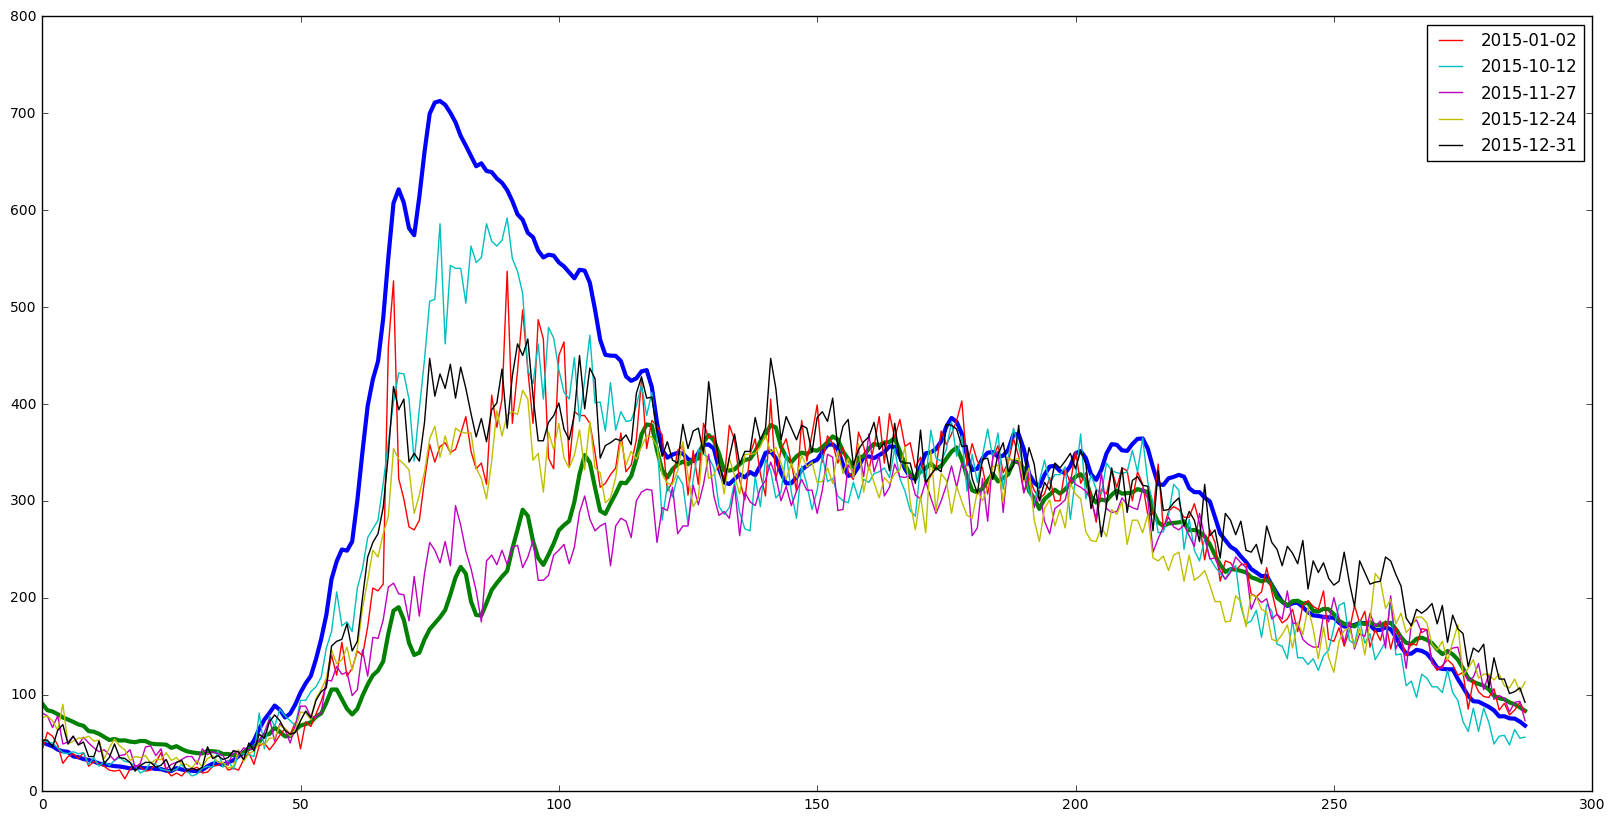

In [ ]:
PlotInteresting(my_fit, bads, my_df, b)

In [ ]:
station_check = {}
bad_stations = []

for station in stations_list[:100]:
    #PlotElbow(np.nan_to_num(b))
    try:
        my_fit, bads, my_df, b = CheckStation(station)
        station_check[station]={'my_fit':my_fit, 'bads':bads, 'my_df':my_df, 'b':b}
        print station, len(bads)
    except:
        bad_stations += station
        print "Bad Station:",station


1100313 107
1100326 108
1100330 51
1100333 21
1100340 86
1100348 19
1100353 54
1100363 133
1100369 111
1100377 16
1100381 110
1100384 26
1100387 138
1100393 15
1100396 110
1100407 182
1100416 19
1100424 122
1100434 23
1100442 24
1100451 61
1100454 16


In [ ]:
badlist  = []
#{'my_fit':my_fit, 'bads':bads, 'my_df':my_df, 'b':b}
for station in station_check:
    sc =  station_check[station]
    #print sc['bads']
    badlist += sc['bads']

    
bad_counts = Counter(badlist)

In [ ]:
s = pd.Series(bad_counts, name='Count')
s.index.name = 'Date'
s = s.reset_index()

s.plot(x='Date')

s = s.sort_values('Count',ascending=False)

def getDateFromDay(i):
    date = dt.date(2015,1,1)
    date = date + dt.timedelta(days=i)
    day_name = "{}".format( date.strftime("%A %d %b"))
    return date #day_name

s.Date = s.Date.apply(getDateFromDay)


calmap.yearplot(s)

s.head(10)

# 12 Oct  
columbus day
a federal holiday but not a state holiday

# 11 Nov
Veterans day

# 27 Nov
black friday

# 19 Jan
mlk day



In [ ]:
s.Count.describe()

In [ ]:
for i, k in bad_counts.iteritems():
    date = dt.date(2015,1,1)
    date = date + dt.timedelta(days=i)
    day_name = "{}".format( date.strftime("%A %d %b %I:%M%p"))
    print day_name , k



In [ ]:
for station in station_check:
    sc =  station_check[station]
    PlotInteresting(sc['my_fit'], sc['bads'], sc['my_df'], sc['b'])